In [1]:
# Import libraries
import torch
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score

In [2]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

In [3]:
# Filter the dataset to only include samples with labels 2, 3, 8, and 9
filtered_train_indices = torch.tensor([idx for idx, label in enumerate(trainset.targets) if label in [2, 3, 8, 9]])
filtered_trainset = torch.utils.data.Subset(trainset, filtered_train_indices)
flatten_trainset = torch.stack([image.view(-1) for image, label in filtered_trainset])
train_targets = torch.tensor([label for _, label in filtered_trainset])  # Extract target values

filtered_test_indices = torch.tensor([idx for idx, label in enumerate(testset.targets) if label in [2, 3, 8, 9]])
filtered_testset = torch.utils.data.Subset(testset, filtered_test_indices)
flatten_testset = torch.stack([image.view(-1) for image, label in filtered_testset])
test_targets = torch.tensor([label for _, label in filtered_testset])  # Extract target values

In [4]:
# Normalizing the data
from sklearn.preprocessing import normalize

trainset_normalized = normalize(flatten_trainset)
testset_normalized = normalize(flatten_testset)

In [5]:
# Kmeans algorithm using euclidean distance
def kmeans_euclidean(data, max_iters=1000, k=[2, 3, 8, 9]):
    # Initialize centroids randomly
    centroids = {label: data[np.random.choice(range(data.shape[0]))] for label in k}
    
    # Create a mapping for labels
    label_mapping = {i: label for i, label in enumerate(k)}
    
    while(1):
        # Assign each data point to the nearest centroid
        distances = np.sqrt(((data - np.array(list(centroids.values()))[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        
        # Map the labels
        labels = np.vectorize(label_mapping.get)(labels)
        
        # Update centroids
        new_centroids = np.array([data[labels == label].mean(axis=0) for label in k])
    
        # Check for convergence
        if np.allclose(np.array(list(centroids.values())), new_centroids):
            break
            
        centroids = {label: new_centroids[i] for i, label in enumerate(k)}
    
    return labels, centroids


In [6]:
# Kmeans algorithm using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

def kmeans_cosine(data, max_iters=100, k=[2, 3, 8, 9]):
    # Initialize centroids randomly
    centroids = {label: data[np.random.choice(range(data.shape[0]))] for label in k}
    
    # Create a mapping for labels
    label_mapping = {i: label for i, label in enumerate(k)}
    
    while(1):
        # Compute cosine similarity
        dot_product = np.dot(data, np.array(list(centroids.values())).T)
        magnitude_a = np.linalg.norm(data)
        magnitude_b = np.linalg.norm(np.array(list(centroids.values())))
        similarity = dot_product / (magnitude_a * magnitude_b)
    
        labels = np.argmax(similarity, axis=1)
        
        # Map the labels
        labels = np.vectorize(label_mapping.get)(labels)
        
        # Update centroids
        new_centroids = np.array([data[labels == label].mean(axis=0) for label in k])
        
        # Check for convergence
        if np.allclose(np.array(list(centroids.values())), new_centroids):
            break
        
        centroids = {label: new_centroids[i] for i, label in enumerate(k)}
    
    return labels, centroids

In [7]:
# Function for SSE calculation 
def calculate_sse(data, centroids, assigned_labels):

    sse = 0
    for i in range (len(data)):
        label = assigned_labels[i]
        centroid = centroids[label]

        distance = np.sqrt(((data[i] - centroid) ** 2).sum())
        sse += distance

    return sse
 

In [9]:
# Perform K-means clustering with Euclidean distance
labels_euclidean, centroids_euclidean = kmeans_euclidean(trainset_normalized)

In [10]:
# Perform k-means clustering using cosine similarity
labels_cosine, centroids_cosine = kmeans_cosine(trainset_normalized)

In [11]:
# Calculate SSE
sse_euclidean = calculate_sse(trainset_normalized, centroids_euclidean, labels_euclidean)
print("Sum of Squared Error (SSE) using euclidean distance:", sse_euclidean)

sse_cosine = calculate_sse(trainset_normalized, centroids_cosine, labels_cosine)
print("Sum of Squared Error (SSE) using cosine similarity:", sse_cosine)

Sum of Squared Error (SSE) using euclidean distance: 16069.1987472899
Sum of Squared Error (SSE) using cosine similarity: 16084.827266390339


In [15]:
# Calculate clustering accuracy 
accuracy_euclidean = accuracy_score(train_targets, labels_euclidean)
print("Clustering accuracy using euclidean distance:", accuracy_euclidean)

accuracy_cosine = accuracy_score(train_targets, labels_cosine)
print("Clustering accuracy using cosine similarity:", accuracy_cosine)

Clustering accuracy using euclidean distance: 0.36983548913725983
Clustering accuracy using cosine similarity: 0.19473397798149775


In [13]:
# PCA
from sklearn.decomposition import PCA

# Apply PCA to extract features
pca = PCA(n_components=50)  # You can adjust the number of components as needed
X_pca = pca.fit_transform(trainset_normalized)

# Perform k-means clustering on the PCA-transformed data
labels_pca, centroids_pca =  kmeans_euclidean(X_pca)

# Calculate clustering accuracy using PCA-transformed data
accuracy_pca = accuracy_score(train_targets, labels_pca)
print("Clustering accuracy using PCA-transformed data:", accuracy_pca)


Clustering accuracy using PCA-transformed data: 0.4694210724601281


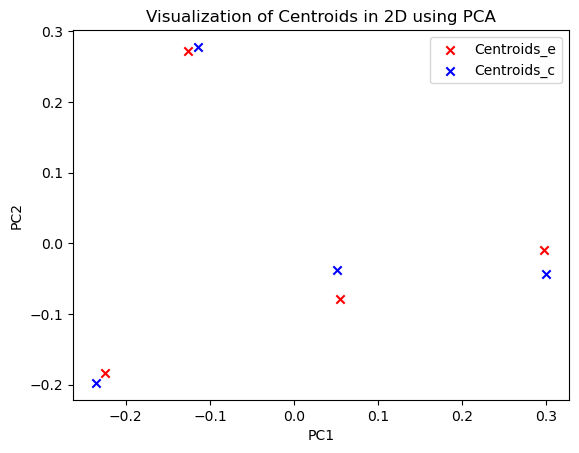

In [23]:
# Plot the centroids
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

centroids_e = pca.fit_transform(np.array(list(centroids_euclidean.values())))
centroids_c = pca.fit_transform(np.array(list(centroids_cosine.values())))

plt.scatter(centroids_e[:, 0], centroids_e[:, 1], marker='x', color='red', label='Centroids_e')
plt.scatter(centroids_c[:, 0], centroids_c[:, 1], marker='x', color='blue', label='Centroids_c')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of Centroids in 2D using PCA')
plt.legend()
plt.show()
